In [1]:
from tqdm.notebook import tqdm
import scanpy as sc
import matplotlib.pyplot as pl
import anndata as ad
import pandas as pd
import numpy as np
import seaborn as sns
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))
%matplotlib inline
import scvelo as scv
scv.settings.verbosity=1

In [2]:
import sys
sys.path.insert(1, '/fast/work/users/peidlis_c/utils/single_cell_rna_seq/scrnaseq_utils/')
# sys.path.insert(1, '/extra/stefan/utils/scrnaseq_utils/')
from scrnaseq_util_functions import *

# Test

In [3]:
adata = sc.datasets.pbmc3k_processed()

  0%|          | 0.00/23.5M [00:00<?, ?B/s]

In [4]:
adata

AnnData object with n_obs × n_vars = 2638 × 1838
    obs: 'n_genes', 'percent_mito', 'n_counts', 'louvain'
    var: 'n_cells'
    uns: 'draw_graph', 'louvain', 'louvain_colors', 'neighbors', 'pca', 'rank_genes_groups'
    obsm: 'X_pca', 'X_tsne', 'X_umap', 'X_draw_graph_fr'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

In [ ]:
variables = adata.obs[['louvain']]
for obs_key in bla:
    

,PC0,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,...,PC40,PC41,PC42,PC43,PC44,PC45,PC46,PC47,PC48,PC49
louvain,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [150]:
variables = adata.obs
y = adata.obsm['X_pca']

rsquared_mat = pd.DataFrame(columns=[f'PC{i+1}' for i in np.arange(y.shape[-1])], index=variables.keys())

tss_all = None
for v in variables.keys():
    curvar = variables[v]
    if len(np.unique(curvar))<=1:
        print(f'Skipping {v} as it has less then 2 unique entries.')
        continue
    
    # Protect against NAs in the metadata.
    keep = ~pd.isna(curvar)
    curvar = curvar[keep]
    y = y[keep, :]
    tss = np.var(y, axis=0) * (y.shape[0] - 1) # rowVars(block) * (ncol(block) - 1) 
print(tss.shape)

(50,)


In [151]:
# design <- model.matrix(~curvar)
# fit <- fitLinearModel(y, design)
# rss <- fit$variance * (nrow(design) - ncol(design))
# rsquared_mat[, V] <- 1 - rss/tss

In [152]:
# linear regression https://cmdlinetips.com/2020/03/linear-regression-using-matrix-multiplication-in-python-using-numpy/
dummy_df = pd.get_dummies(curvar)  # dummy encoding
dM = np.hstack((np.ones((len(dummy_df), 1)), dummy_df.values))  # add 1 first col for intercept for design matrix
beta_hat = np.linalg.inv(dM.T.dot(dM)).dot(dM.T).dot(y)  # linear regression
yhat = dM.dot(beta_hat)  # prediction

In [153]:
# R^2
residuals = y-yhat
mean_rsqu = np.mean(residuals**2, axis=0)
# variance, a numeric vector of residual variances per row of x. Computed by summing the residual effects from the fitted model.
residual_var = np.var(residuals, axis=0)  # must have dim == dim(tss)
rss = residual_var * (dM.shape[0] - dM.shape[1])  # nrow - ncol of design matrix
print(rss.shape)
rsquared_mat.loc[v] = (1 - rss/tss) * 100
rsquared_mat

(50,)


,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,...,PC41,PC42,PC43,PC44,PC45,PC46,PC47,PC48,PC49,PC50
n_genes,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
percent_mito,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
n_counts,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
louvain,70.512869,85.009181,82.490103,71.848159,54.645876,28.87173,10.93661,14.344143,4.862346,1.387196,...,0.370586,0.346366,0.819412,0.363075,0.483046,0.37743,0.393805,0.413399,0.39234,0.50155


# Implementation

In [6]:
from sklearn.linear_model import LinearRegression
def getExplanatoryPCs(adata, obs_keys=None, use_rep='X_pca'):
    """Computes percentage of variance explained in PCA by variables in adata.obs.
    
    Python port of scater R function https://rdrr.io/github/davismcc/scater/src/R/getExplanatoryPCs.R

    returns a pandas.DataFrame where columns are PCs and rows are obs_keys
    """
    obs_keys = list(obs_keys) if isinstance(obs_keys, str) else obs_keys
    variables = adata.obs if obs_keys==None else adata.obs[obs_keys]
    if use_rep=='X_pca' and 'X_pca' not in adata.obsm.keys():
        print(f'Could not find X_pca in adata.obsm. Running sc.pp.pca(adata)...')
        sc.pp.pca(adata)
    Y = adata.obsm[use_rep]
    
    # prepare output format
    rsquared_mat = pd.DataFrame(columns=[f'PC{i+1}' for i in np.arange(Y.shape[-1])], index=variables.columns)
    
    for v in variables:
        curvar = adata.obs[v]
        
        if len(pd.unique(curvar))<=1:
            print(f'Skipping {v} as it has less then 2 unique entries.')
            continue

        # Protect against NAs in the metadata.
        keep = ~pd.isna(curvar)
        curvar = curvar[keep]
        y = Y[keep, :] 
        
        if pd.api.types.is_numeric_dtype(curvar):
            X = curvar.values[:, np.newaxis]
        else:
            X = pd.get_dummies(curvar).values
        
        regression = LinearRegression()
        linear_model = regression.fit(X, y)
        yhat = linear_model.predict(X)
        
        tss = np.sum((y-np.mean(y, axis=0))**2, axis=0)  # total sum of squares
        residuals = y - yhat
        rss = np.sum(residuals**2, axis=0)  # residual sum of squares
        
        r_squared = 1 - rss/tss  # classical R^2
        adjustment_factor = (y.shape[0] - 1) / (y.shape[0] - X.shape[1] - 1)  # degrees of freedom of the estimates
        r_squared_adj = 1 - (rss/tss) * adjustment_factor  # adjusted R^2 for multiple linear model
        rsquared_mat.loc[v] = r_squared_adj * 100

    return rsquared_mat

In [7]:
import matplotlib.ticker as mtick
def getExplanatoryPCs_weighted(adata, obs_keys=None, use_rep='X_pca', normalize=False,
                               sort=True, ascending=False, plot=False, show=True, style="whitegrid"):
    mat = getExplanatoryPCs(adata, obs_keys=obs_keys, use_rep=use_rep)
    # weighted sum, variation explained in data via PCA
    weights = adata.uns['pca']['variance_ratio']
    if normalize:
        weights /= np.sum(weights)
    y = np.dot(mat.values, weights)  # PC variance explained weighted sum
    tab = pd.DataFrame(y, index=mat.index, columns=['weighted_score']).T
    if sort:
        tab = tab.sort_values(by='weighted_score', axis=1, ascending=ascending)
    if plot:
        with sns.axes_style(style):
            ax = sns.barplot(data=tab)
        pl.xticks(rotation=90)
        pl.ylabel('% Variance Explained')
        pl.grid(True)
        ax.yaxis.set_major_formatter(mtick.PercentFormatter())
        if show: pl.show()
    return tab

# Example

In [16]:
adata = sc.read('../exampledataset/exampledataset.h5')

# adata = sc.read("/extra/cluster_archiv/scrnaseq/scperturb/h5_demuxed/OT227_filtered_annotated_scrnaseq_data.h5")
adata.obs = adata.obs.rename({'condition': 'perturbation'}, axis=1)
adata.obs.perturbation = adata.obs.perturbation.cat.rename_categories({'CTRL': 'control'})
adata = adata[adata.obs.perturbation!='nan'].copy()

In [17]:
adata.layers['counts'] = adata.X
sc.pp.normalize_per_cell(adata)
sc.pp.log1p(adata)

sc.pp.pca(adata, n_comps=30)
# sc.pp.neighbors(adata)
# sc.tl.umap(adata)

In [18]:
# % Variation explained in each PC
mat = getExplanatoryPCs(adata, ['perturbation', 'n_counts'])
mat

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,...,PC21,PC22,PC23,PC24,PC25,PC26,PC27,PC28,PC29,PC30
perturbation,4.077498,3.580188,9.251373,17.950131,2.874707,12.620021,0.302303,8.696287,0.268509,-0.283364,...,4.783522,0.31324,0.706895,2.71975,1.132081,1.370202,0.736453,2.0717,-0.021567,1.822947
n_counts,15.099931,24.955494,0.366771,0.395381,0.063604,0.209796,0.160962,2.806515,0.215894,0.114959,...,-0.120962,0.030077,-0.075793,-0.133598,-0.128591,0.015759,-0.133276,-0.123751,-0.071168,0.096267


In [19]:
# % Variation explained in data
getExplanatoryPCs_weighted(adata, ['perturbation', 'n_counts'])

,n_counts,perturbation
weighted_score,1.281891,1.010595


In [20]:
# % Variation explained in PCA
getExplanatoryPCs_weighted(adata, ['perturbation', 'n_counts'], normalize=True)

,n_counts,perturbation
weighted_score,6.288538,4.957652


## Per class in a obs variable ("Confusing", deprecated)

Idea: 
- For each perturbation, define a dummy variable that is 1 for cells of that perturbation and zero otherwise. 
- Compute the weighted sum score per perturbation to get an estimate of the influence of each perturbation on the PCA.

Critique:
- if you have more perturbations that do the same, they will have a larger influence even if each on its own does not actually have a large effect

In [98]:
perturbations = pd.unique(adata.obs.perturbation)
tdata = adata.copy()
for perturbation in perturbations:
    tdata.obs[perturbation] = [x if x==perturbation else 'other' for x in tdata.obs.perturbation]
mat_ = getExplanatoryPCs(tdata, list(perturbations))
weights = adata.uns['pca']['variance_ratio']
y = np.dot(mat_.values, weights)  # PC variance explained weighted sum
tab = pd.DataFrame(y, index=perturbations, columns=['weighted_score'])
tab.T

,AKT,EGFR,ERK,BRAF,MEK,Pi3K,control,FGFR,MEK+EGFR,EGFR+FGFR,Mk2,Mst1/2,p38,mTORC1,mTORC1/2,Chk1,TGFBR,GSK3b,IKK,Chk1+Mk2
weighted_score,0.0826476,0.0716171,0.0177606,0.0337876,0.314624,0.0150503,0.152834,0.0175703,0.332224,0.0641998,0.0378599,0.0383288,0.0175117,0.0494779,0.103026,0.0314207,0.0325115,0.0835235,0.0499467,0.0155497


In [65]:
import seaborn as sns
tab_ = tab.reset_index().sort_values('weighted_score', ascending=False)
ax = sns.barplot(data=tab_, x='weighted_score', y='index', order=tab_['index'])
pl.ylabel('perturbation')
pl.xlabel('Weighted PC explanation score\n(Estimated influence on PCA)')
pl.show()

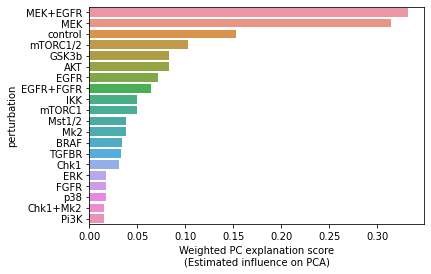

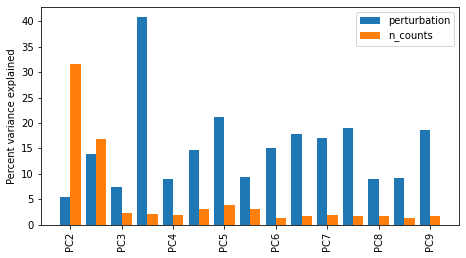

In [26]:
def plotExplanatoryPCs(mat, keys=None, PCs=15, ax=None, show=True):
    bars = np.min([len(mat.columns), PCs]) if PCs!=None else len(mat.columns)
    keys = mat.index if keys is None else keys
    
    ax = pl.subplots(1,1,figsize=[bars / 2, 4])[1] if ax==None else ax
    
    x = np.arange(bars)
    width = 0.8 / len(keys) 
    for i, key in enumerate(keys):
        ax.bar(x + width * i - 0.4 + width/2, mat.loc[key][:bars] + np.random.uniform(0,5), width=width, label=key)
    ax.set_xticklabels(mat.columns[:bars], rotation=90)
    ax.set_ylabel('Percent variance explained')
    ax.legend()
    if show: 
        pl.show()
    else:
        return ax
plotExplanatoryPCs(mat)

In [94]:
from scipy.stats import entropy

In [103]:
PC_entropy = entropy(np.array(mat.values, dtype=float), axis=0)

In [104]:
key_entropy = entropy(np.array(mat.values, dtype=float), axis=1)

In [105]:
key_entropy

array([2.42080451, 3.91062478, 3.89689355, 2.29187854])

In [114]:
X=np.array(mat.values, dtype=float)

In [116]:
for i in range(4):
    y=entropy(X[i], np.sum(X, axis=0))
    print(y)

0.5512031696459297
1.8621101288946622
1.7745862225804159
0.0010022150594933455


In [119]:
np.mean(X, axis=1)

array([0.18480331, 0.03886549, 0.04029414, 9.0987176 ])

# Apply to more datasets

In [3]:
# path = "/extra/stefan/data/perturbation_resource_paper/"
path = '/fast/work/users/peidlis_c/data/perturbation_resource_paper/'
files = get_files(path, full_path=False)
len(files)

16

In [ ]:
tabs = {}
for file in tqdm(files[:3]):
    data = sc.read(f'{path}{file}')
    print(file)
    calc_qc(data)
    sc.pp.filter_cells(data, min_counts=500)
    sc.pp.filter_genes(data, min_cells=50)
    sc.pp.normalize_per_cell(data)
    sc.pp.log1p(data)
    tab = getExplanatoryPCs_weighted(data, ['perturbation', 'ncounts', 'ngenes', 'percent_mito'], plot=False, normalize=True)
    tabs[file[:-3]] = tab

  0%|                                                                                                                                    | 0/3 [00:00<?, ?it/s]

SrivatsanTrapnell2020_sciplex3.h5
Could not reliably detect organism from mito genes. Setting as human.
Could not find X_pca in adata.obsm. Running sc.pp.pca(adata)...


In [48]:
df = pd.concat(tabs).reset_index(level=[1]).drop('level_1', axis=1)

In [49]:
df['perturbation']

DatlingerBock2017    0.574512
ShifrutMarson2018    0.634414
ZhaoSims2021         6.125548
Name: perturbation, dtype: object

In [43]:
df['perturbation']

DatlingerBock2017    0.083284
ShifrutMarson2018    0.083691
ZhaoSims2021         1.106205
Name: perturbation, dtype: object

# Notes

- this is a **relative** measure of effect sizes, i.e. you can compare effect sizes within a dataset, not across datasets